In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
import random
import torch
import pdb
from monai.networks.nets import UNet as MUNet

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def out_to_seg(img, num_classes):
    out = torch.zeros((1,*img.shape[1:])).to(img.device)
    for i,layer in enumerate(img) :
        out += layer*(i*255/(num_classes-1))
    return out

In [7]:
from numpy import isnan


def runTraining():
    print('-' * 40)
    print('~~~~~~~~  Starting the training... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 8
    batch_size_val = 8
    lr =   0.0001  # Learning Rate
    epoch = 200 # Number of epochs
    
    root_dir = './Data/'

    print(' Dataset: {} '.format(root_dir))

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                      root_dir,
                                                      transform=transform,
                                                      mask_transform=mask_transform,
                                                      augment=True,
                                                      equalize=True)

    train_loader_full = DataLoader(train_set_full,
                              batch_size=batch_size,
                              worker_init_fn=np.random.seed(0),
                              num_workers=0,
                              shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,
                            batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = 'Test_Model'
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    # net = UNet(num_classes)
    net=MUNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=2,
        channels=(4, 8, 16, 32, 64, 128),
        strides=(1, 1, 1, 2, 2),
    )
    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax()
    CE_loss = torch.nn.MSELoss( reduction="sum")

    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    ### To save statistics ####
    lossTotalTraining = []
    Best_loss_val = 1000
    BestEpoch = 0
    
    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING
    
    ## FOR EACH EPOCH
    for i in range(epoch):
        net.train()
        lossEpoch = []
        DSCEpoch = []
        DSCEpoch_w = []
        num_batches = len(train_loader_full)
        
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)
            
            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = softMax(net(images))
            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            encoded_classes = batch_one_hot_encode_2_chan(segmentation_classes, 2)
            encoded_classes[:,1,:,:]=encoded_classes[:, -3:, :, :].sum(dim=1, keepdim=True)
            # COMPUTE THE LOSS
            CE_loss_value = CE_loss(net_predictions, encoded_classes[:,:2, :, :]) # XXXXXX and YYYYYYY are your inputs for the CE
            # element_by_layers = predToSegmentation(net_predictions).sum(dim=(2,3))
            # prob_by_layer = (element_by_layers/(element_by_layers.sum()))
            # piecewise_diff = prob_by_layer - torch.Tensor([0.8,0.2]).to(prob_by_layer.device)
            # shannon = torch.pow(piecewise_diff, 2)
            lossTotal = CE_loss_value
            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
            CE_loss_value.backward()
            optimizer.step()
            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(lossTotal.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                             prefix="[Training] Epoch: {} ".format(i) ,
                            length=15,
                             suffix=" Loss: {:.4f}, ".format(lossTotal))

        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()

        lossTotalTraining.append(lossEpoch)

        printProgressBar(num_batches, num_batches,
                             done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))

        
        ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        if not os.path.exists('./models/' + modelName):
            os.makedirs('./models/' + modelName)
        if i == epoch-1:
            torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            
        np.save(os.path.join(directory, 'Losses.npy'), lossTotalTraining)
    return net


In [8]:
testnet = runTraining()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
 Dataset: ./Data/ 
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 166,104
~~~~~~~~~~~ Starting the training ~~~~~~~~~~


RuntimeError: expand(torch.cuda.FloatTensor{[8, 1, 256, 256]}, size=[8, 256, 256]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

In [41]:
# mod = UNet(num_classes=4).cuda()
# mod.load_state_dict(torch.load("models/Test_Model/49_Epoch"))
mod=testnet
transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [42]:
val_set = medicalDataLoader.MedicalImageDataset('train',
                                                    "./Data/",
                                                    transform=transform,
                                                    mask_transform=transform,
                                                    equalize=False)

val_loader = DataLoader(val_set,
                            batch_size=2,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)
inference(mod, val_loader, "Test_Model", 99)

[Inference] Segmentation Done !                                                                              


0.14851381

torch.return_types.max(
values=tensor([[0.8203, 0.9187, 0.9304,  ..., 0.9028, 0.9316, 0.8106],
        [0.8966, 0.9714, 0.9696,  ..., 0.9666, 0.9823, 0.9427],
        [0.8955, 0.9712, 0.9633,  ..., 0.9632, 0.9753, 0.9357],
        ...,
        [0.9536, 0.9894, 0.9843,  ..., 0.9690, 0.9787, 0.9432],
        [0.9125, 0.9904, 0.9850,  ..., 0.9827, 0.9881, 0.9569],
        [0.8138, 0.9380, 0.9363,  ..., 0.9060, 0.9198, 0.8533]]),
indices=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]))


(tensor([0.0000, 0.3333, 0.6667, 1.0000]),
 './Data/train\\Img\\patient006_01_11.png')

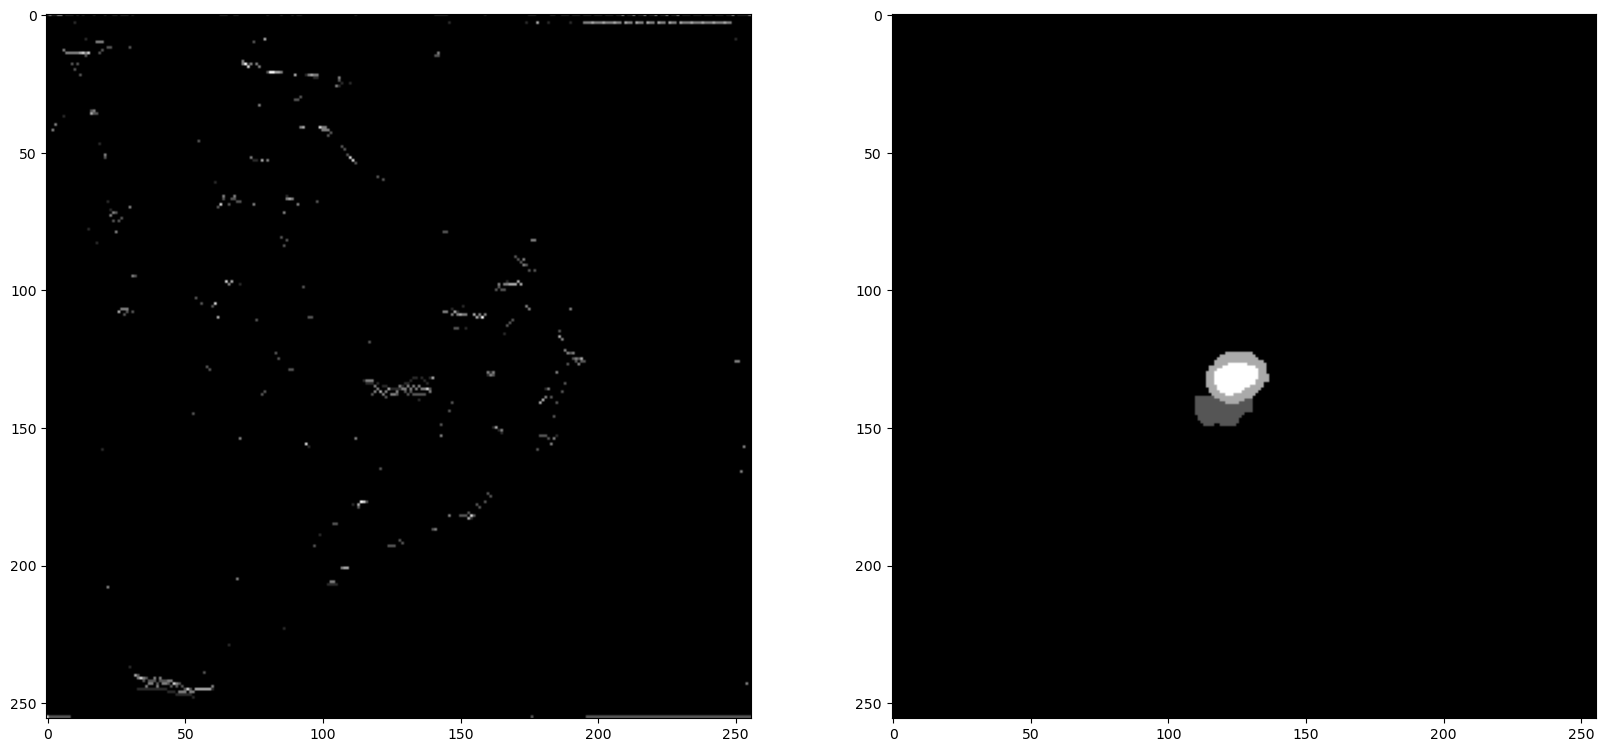

In [44]:
img, mask, path = val_set[2]
out = mod(to_var(img)[None,:])
out_cpu =out.detach().cpu()[0]
out_cpu = torch.nn.functional.softmax(out_cpu, dim=0)
segmentation_image = out_to_seg(predToSegmentation(out_cpu),3)

# Now, concatenated_output has shape (batch_size, 1, num_classes, height, width)
# If you want to remove the singleton dimension, you can use squeeze
print(out_cpu.max(dim=0))
fig, plots = plt.subplots(1,2, figsize=(20,20))
plots[0].imshow(segmentation_image.permute(1,2,0), cmap="gray")
plots[1].imshow(mask.permute(1,2,0), cmap="gray")
mask.unique(), path
